# DPT pseudotime and cell cycle scores

### Combined 10 donors (NO SPL3)

### (excluding mature clusters 20, 25, 26 @ leiden resolution 1.2)

#### hpb29

Date: 2021-01-11

In [1]:
%matplotlib nbagg

import warnings
warnings.filterwarnings('ignore')

import os, sys, json, operator, getpass
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import scanpy as sc

from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import tabulate

In [2]:
with open('/.singularity.d/labels.json') as fh:
    singularity = json.load(fh)
    
singularity['Version']

'mictlan.20f'

In [3]:
sc.settings.verbosity = 3             # show some output
sc.settings.file_format_figs = 'svg'  # set this to 'svg' (notebook) or 'pdf' (files) if you want vector graphics
sc.settings.savefigs = False

sc.set_figure_params(dpi=150)
sc.settings._vector_friendly = True

In [4]:
home = str(Path.home())
user = getpass.getuser()

basedir = os.path.join(home, 'databoard/users', user, '2020/SLX19841/')

sc.settings.writedir = os.path.join(basedir, 'analysis/h5ad/')

---

# Skip ahead for re-entry

---

In [5]:
%%time
data = sc.read('20210109_COMBO10_NO_SPL3_Seurat3_Integrated_lognorm_annot_DR_silhouette_WRS')

CPU times: user 27.9 s, sys: 2.91 s, total: 30.9 s
Wall time: 54.8 s


### leiden resolution 1.2

In [6]:
grouping = 'leiden.1.2'

Remove mature cells clusters

In [7]:
data[~data.obs[grouping].isin(['20', '25', '26']) , :].shape

(117235, 24332)

In [8]:
selection = data[~data.obs[grouping].isin(['20', '25', '26']) , :].copy()

In [9]:
sc.tl.diffmap(selection)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9982469  0.9965096  0.99353945 0.9903222  0.98926437
     0.98870707 0.98835546 0.98760027 0.98690456 0.98569524 0.98427683
     0.98356783 0.9808983  0.97954684]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:10)


# Show only BM cells from cluster 4

Acquire coordinates (for usage below) by hovering mouse over interactive version of plot above

<IPython.core.display.Javascript object>


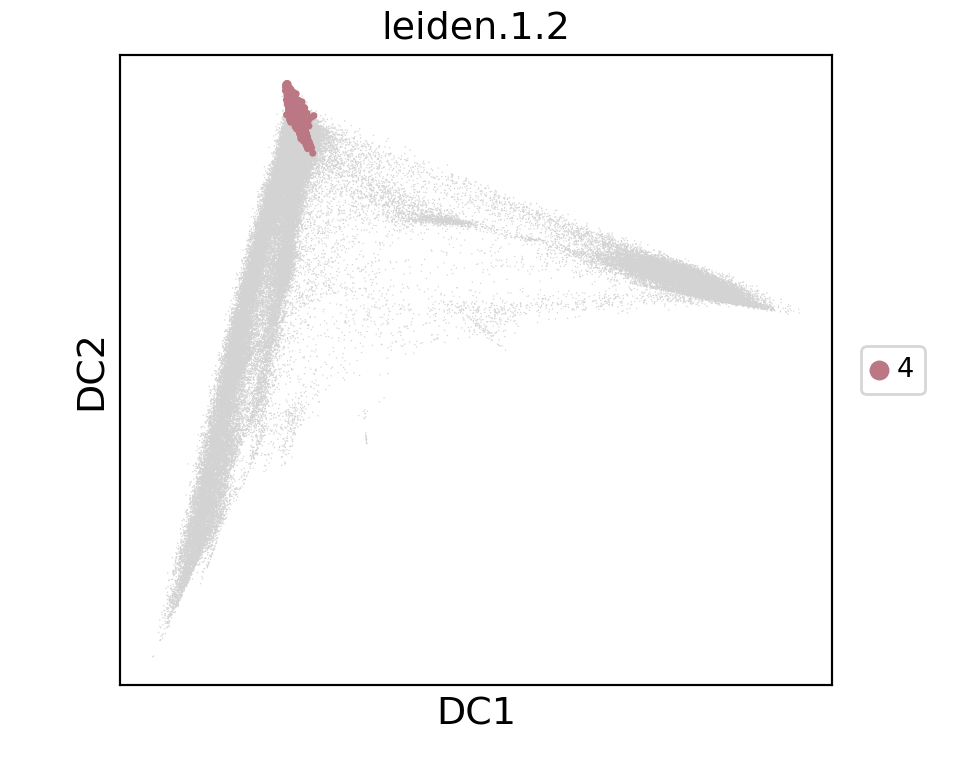

In [11]:
fig, ax = plt.subplots(squeeze=True, figsize=(5, 4))
fig.tight_layout()

sc.pl.diffmap(selection, ax=ax)
sc.pl.diffmap(selection[ np.logical_and(selection.obs[grouping] == '4', selection.obs['organ'] =='BM') ,:], 
                            color=[grouping], ax=ax)

fig.subplots_adjust(right=0.85)

handles, labels = ax.get_legend_handles_labels()

# re-sorting labels
labels = [int(x) for x in labels]
hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
handles2, labels2 = zip(*hl)

ax.legend(handles2, labels2)

lgnd = ax.legend(handles2, labels2, loc=7, scatterpoints=1, fontsize=10, bbox_to_anchor=(1.15, 0.5))
for i in range(0, len(handles)):
     lgnd.legendHandles[i]._sizes = [40]

---

arbitrarily picked a Y coordinate located in a cell closer to "tip"

x -0.00109

y 0.00363

Backtrack cell identity to use as root

In [12]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

**Using the same cell as DPT root as the one previously selected for the resolution 0.9**

In [13]:
selection[selection.obs.index == '_04_CGTAGTATCGATGGAG.1.1', :].obs[['donor', 'organ', 'leiden.1.2']]

donor organ leiden.1.2
_04_CGTAGTATCGATGGAG.1.1  DOD4    BM          4

In [14]:
selection.obs.loc['_04_CGTAGTATCGATGGAG.1.1']

batch                     3
n_counts               6663
n_genes                1829
library             SIGAB12
donor                  DOD4
organ                    BM
seurat_clusters           1
leiden.0.6                0
leiden.0.7                0
leiden.0.8                0
leiden.0.9                0
leiden.1.0                1
leiden.1.1                7
leiden.1.2                4
leiden.1.3                7
silhouette.0.6     0.267859
silhouette.0.7     0.237232
silhouette.0.8      0.27414
silhouette.0.9     0.184275
silhouette.1.0     0.229303
silhouette.1.1     0.268836
silhouette.1.2     0.217229
silhouette.1.3     0.211503
Name: _04_CGTAGTATCGATGGAG.1.1, dtype: object

In [15]:
selection[selection.obs.index == '_04_CGTAGTATCGATGGAG.1.1', :].obsm['X_diffmap']

ArrayView([[-3.3911814e-03, -1.1272706e-03,  3.6560933e-03,
            -1.0262395e-03, -1.5678112e-03, -1.4693975e-03,
             3.3386229e-04, -2.2321732e-03, -8.8624474e-05,
             2.0014362e-03,  8.3007046e-04,  1.4428744e-03,
            -2.2338418e-04, -5.7680970e-03,  4.9597779e-03]],
          dtype=float32)

Use Y coord to find cell index in DR coordinates array

In [16]:
np.where(selection.obsm['X_diffmap'][:,2] == 3.6560933e-03)

(array([46056]),)

In [17]:
selection.uns['iroot'] = 46056

In [18]:
selection.obs['is_root'] = selection.obs.index == '_04_CGTAGTATCGATGGAG.1.1'

In [19]:
cmap = mpl.colors.ListedColormap(['grey', 'red'])

<IPython.core.display.Javascript object>


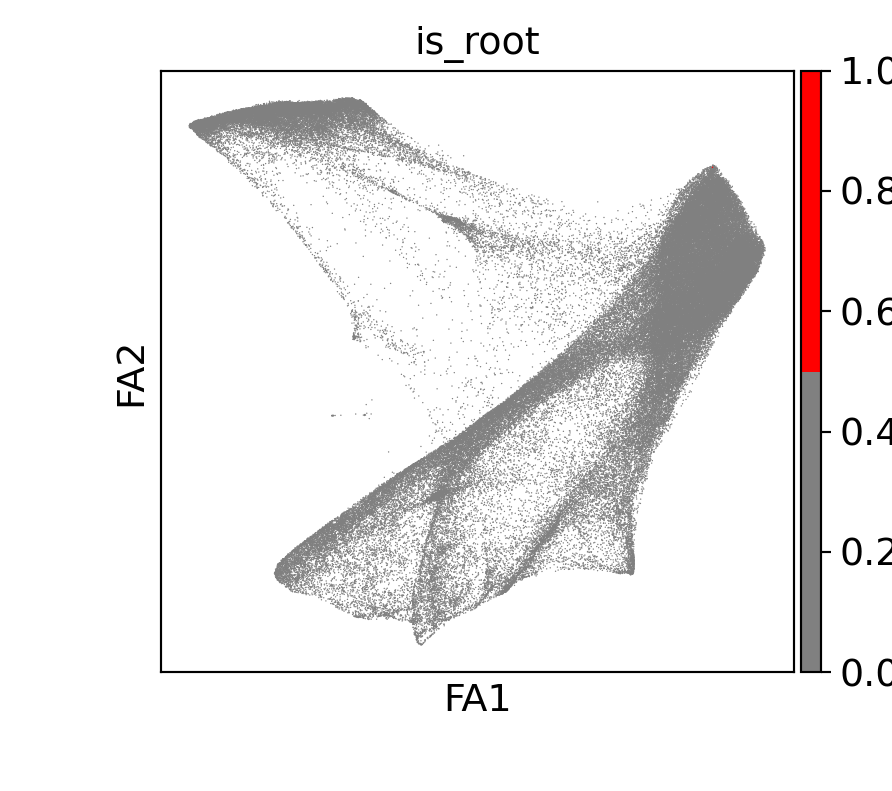

In [20]:
sc.pl.draw_graph( selection, color=['is_root'], cmap=cmap )

## Calculate pseudotime

In [21]:
sc.tl.dpt(selection, n_dcs=15)

computing Diffusion Pseudotime using n_dcs=15
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [23]:
selection.obs['dpt_pseudotime_rank'] = stats.rankdata(selection.obs['dpt_pseudotime'])

<IPython.core.display.Javascript object>


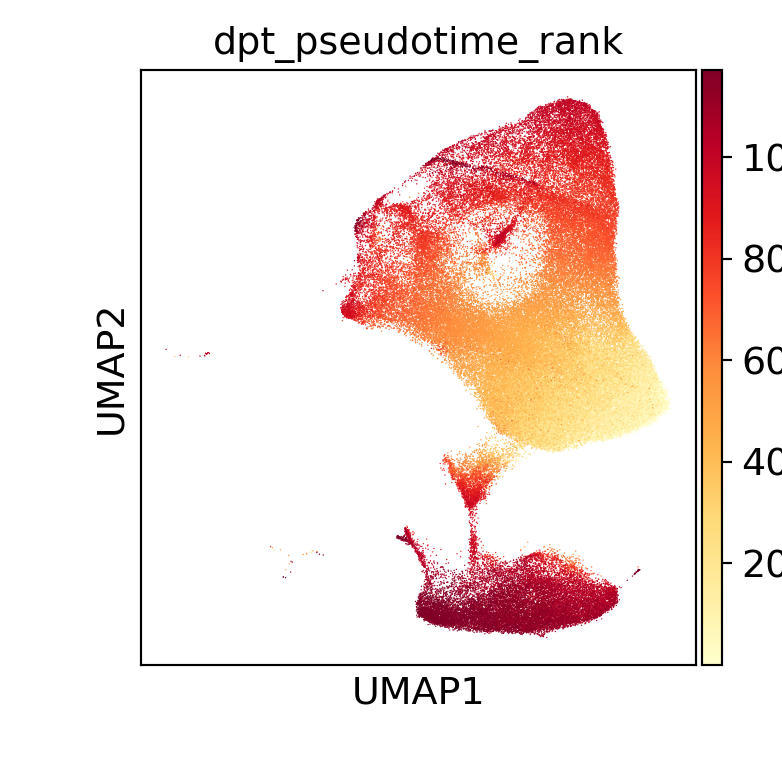

In [25]:
sc.pl.umap(selection, color=['dpt_pseudotime_rank'], cmap='YlOrRd')

# Cell cycle scores

In [26]:
cell_cycle_genes = [x.strip() for x in open('/home/hpb29/LocalApps/notebooks/EL/Nicole/2019/bioRxiv/regev_lab_cell_cycle_genes.txt')]

In [27]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [29]:
sc.tl.score_genes_cell_cycle(selection, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    516 total control genes are used. (0:00:04)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    600 total control genes are used. (0:00:05)
-->     'phase', cell cycle phase (adata.obs)


In [30]:
selection.uns['phase_colors'] = ['#1f77b4', '#ff7f0e', '#2ca02c']

In [31]:
sc.settings._vector_friendly = True

<IPython.core.display.Javascript object>


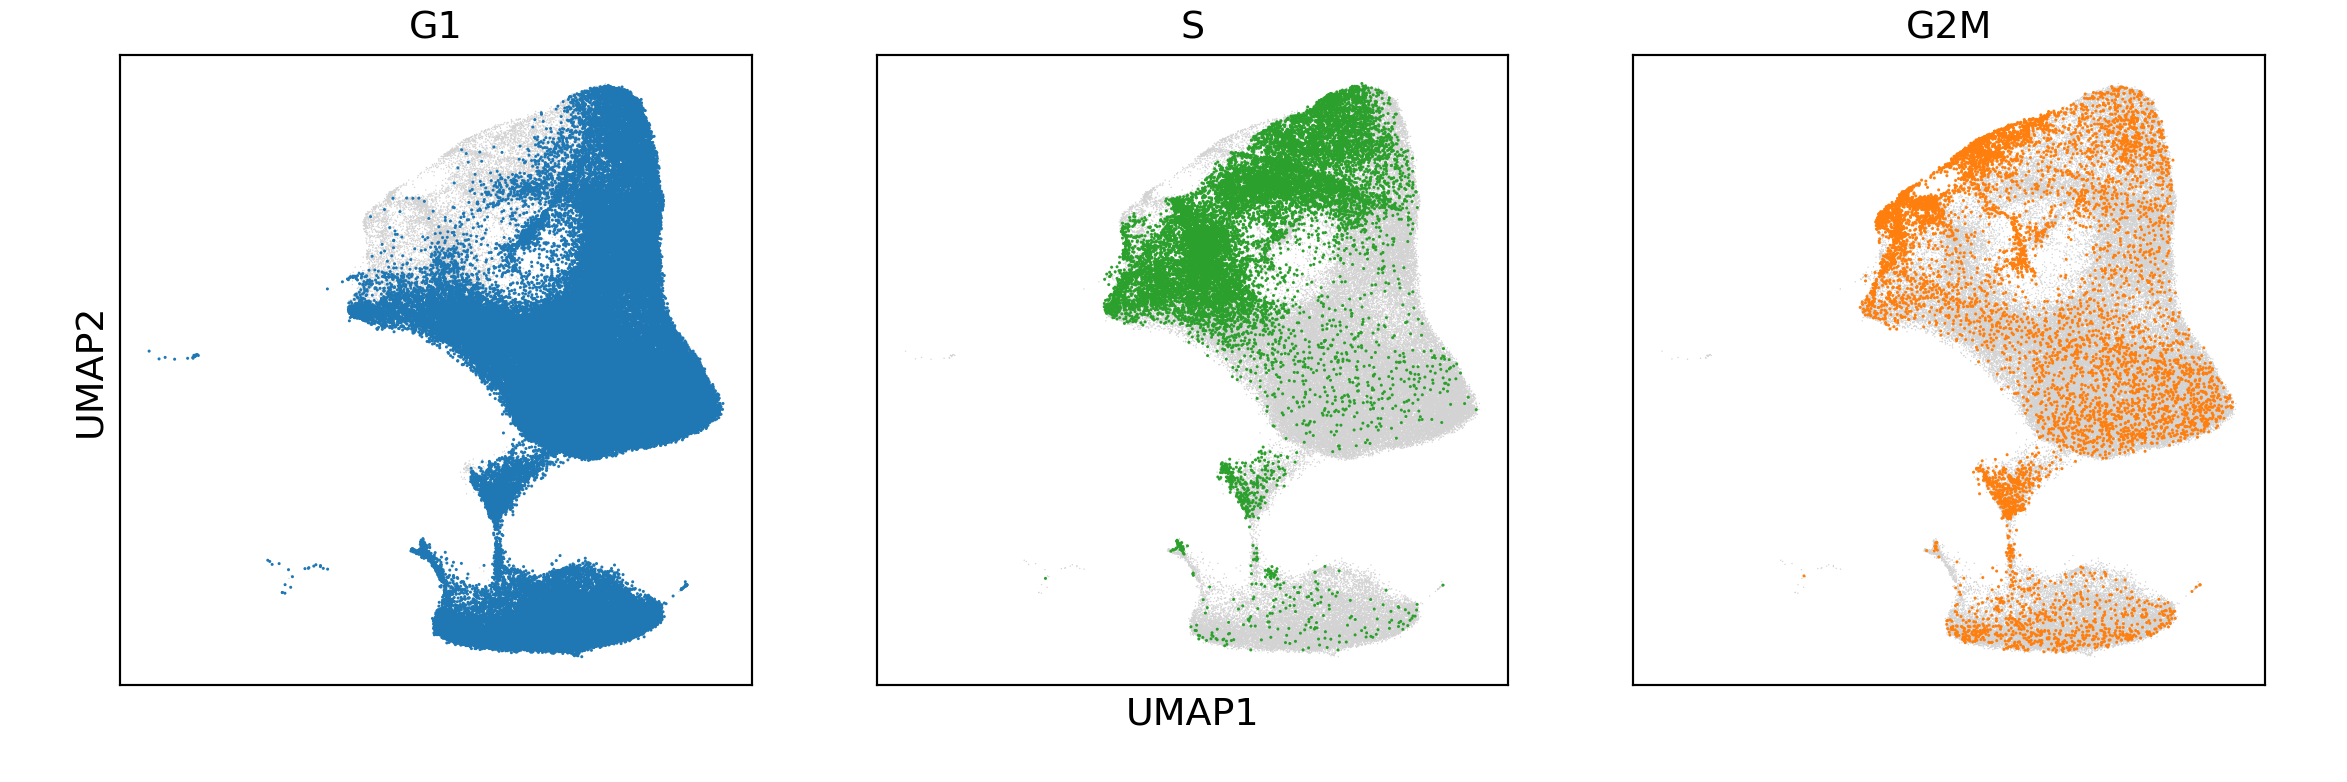

In [33]:
fig, ax = plt.subplots(1,3, sharey=True, squeeze=True, figsize=(12,4))
fig.tight_layout()

sc.pl.umap(selection, ax=ax[0])
sc.pl.umap(selection[selection.obs.phase == 'G1', :], color=['phase'], ax=ax[0], title='G1')
ax[0].collections[1].set_sizes([5])

sc.pl.umap(selection, ax=ax[1])
sc.pl.umap(selection[selection.obs.phase == 'S', :], color=['phase'], ax=ax[1], title='S')
ax[1].collections[1].set_sizes([5])

sc.pl.umap(selection, ax=ax[2])
sc.pl.umap(selection[selection.obs.phase == 'G2M', :], color=['phase'], ax=ax[2], title='G2M')
ax[2].collections[1].set_sizes([5])

ax[0].get_xaxis().set_visible(False)
ax[2].get_xaxis().set_visible(False)

ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

ax[0].get_legend().set_visible(False)
ax[1].get_legend().set_visible(False)
ax[2].get_legend().set_visible(False)

<IPython.core.display.Javascript object>


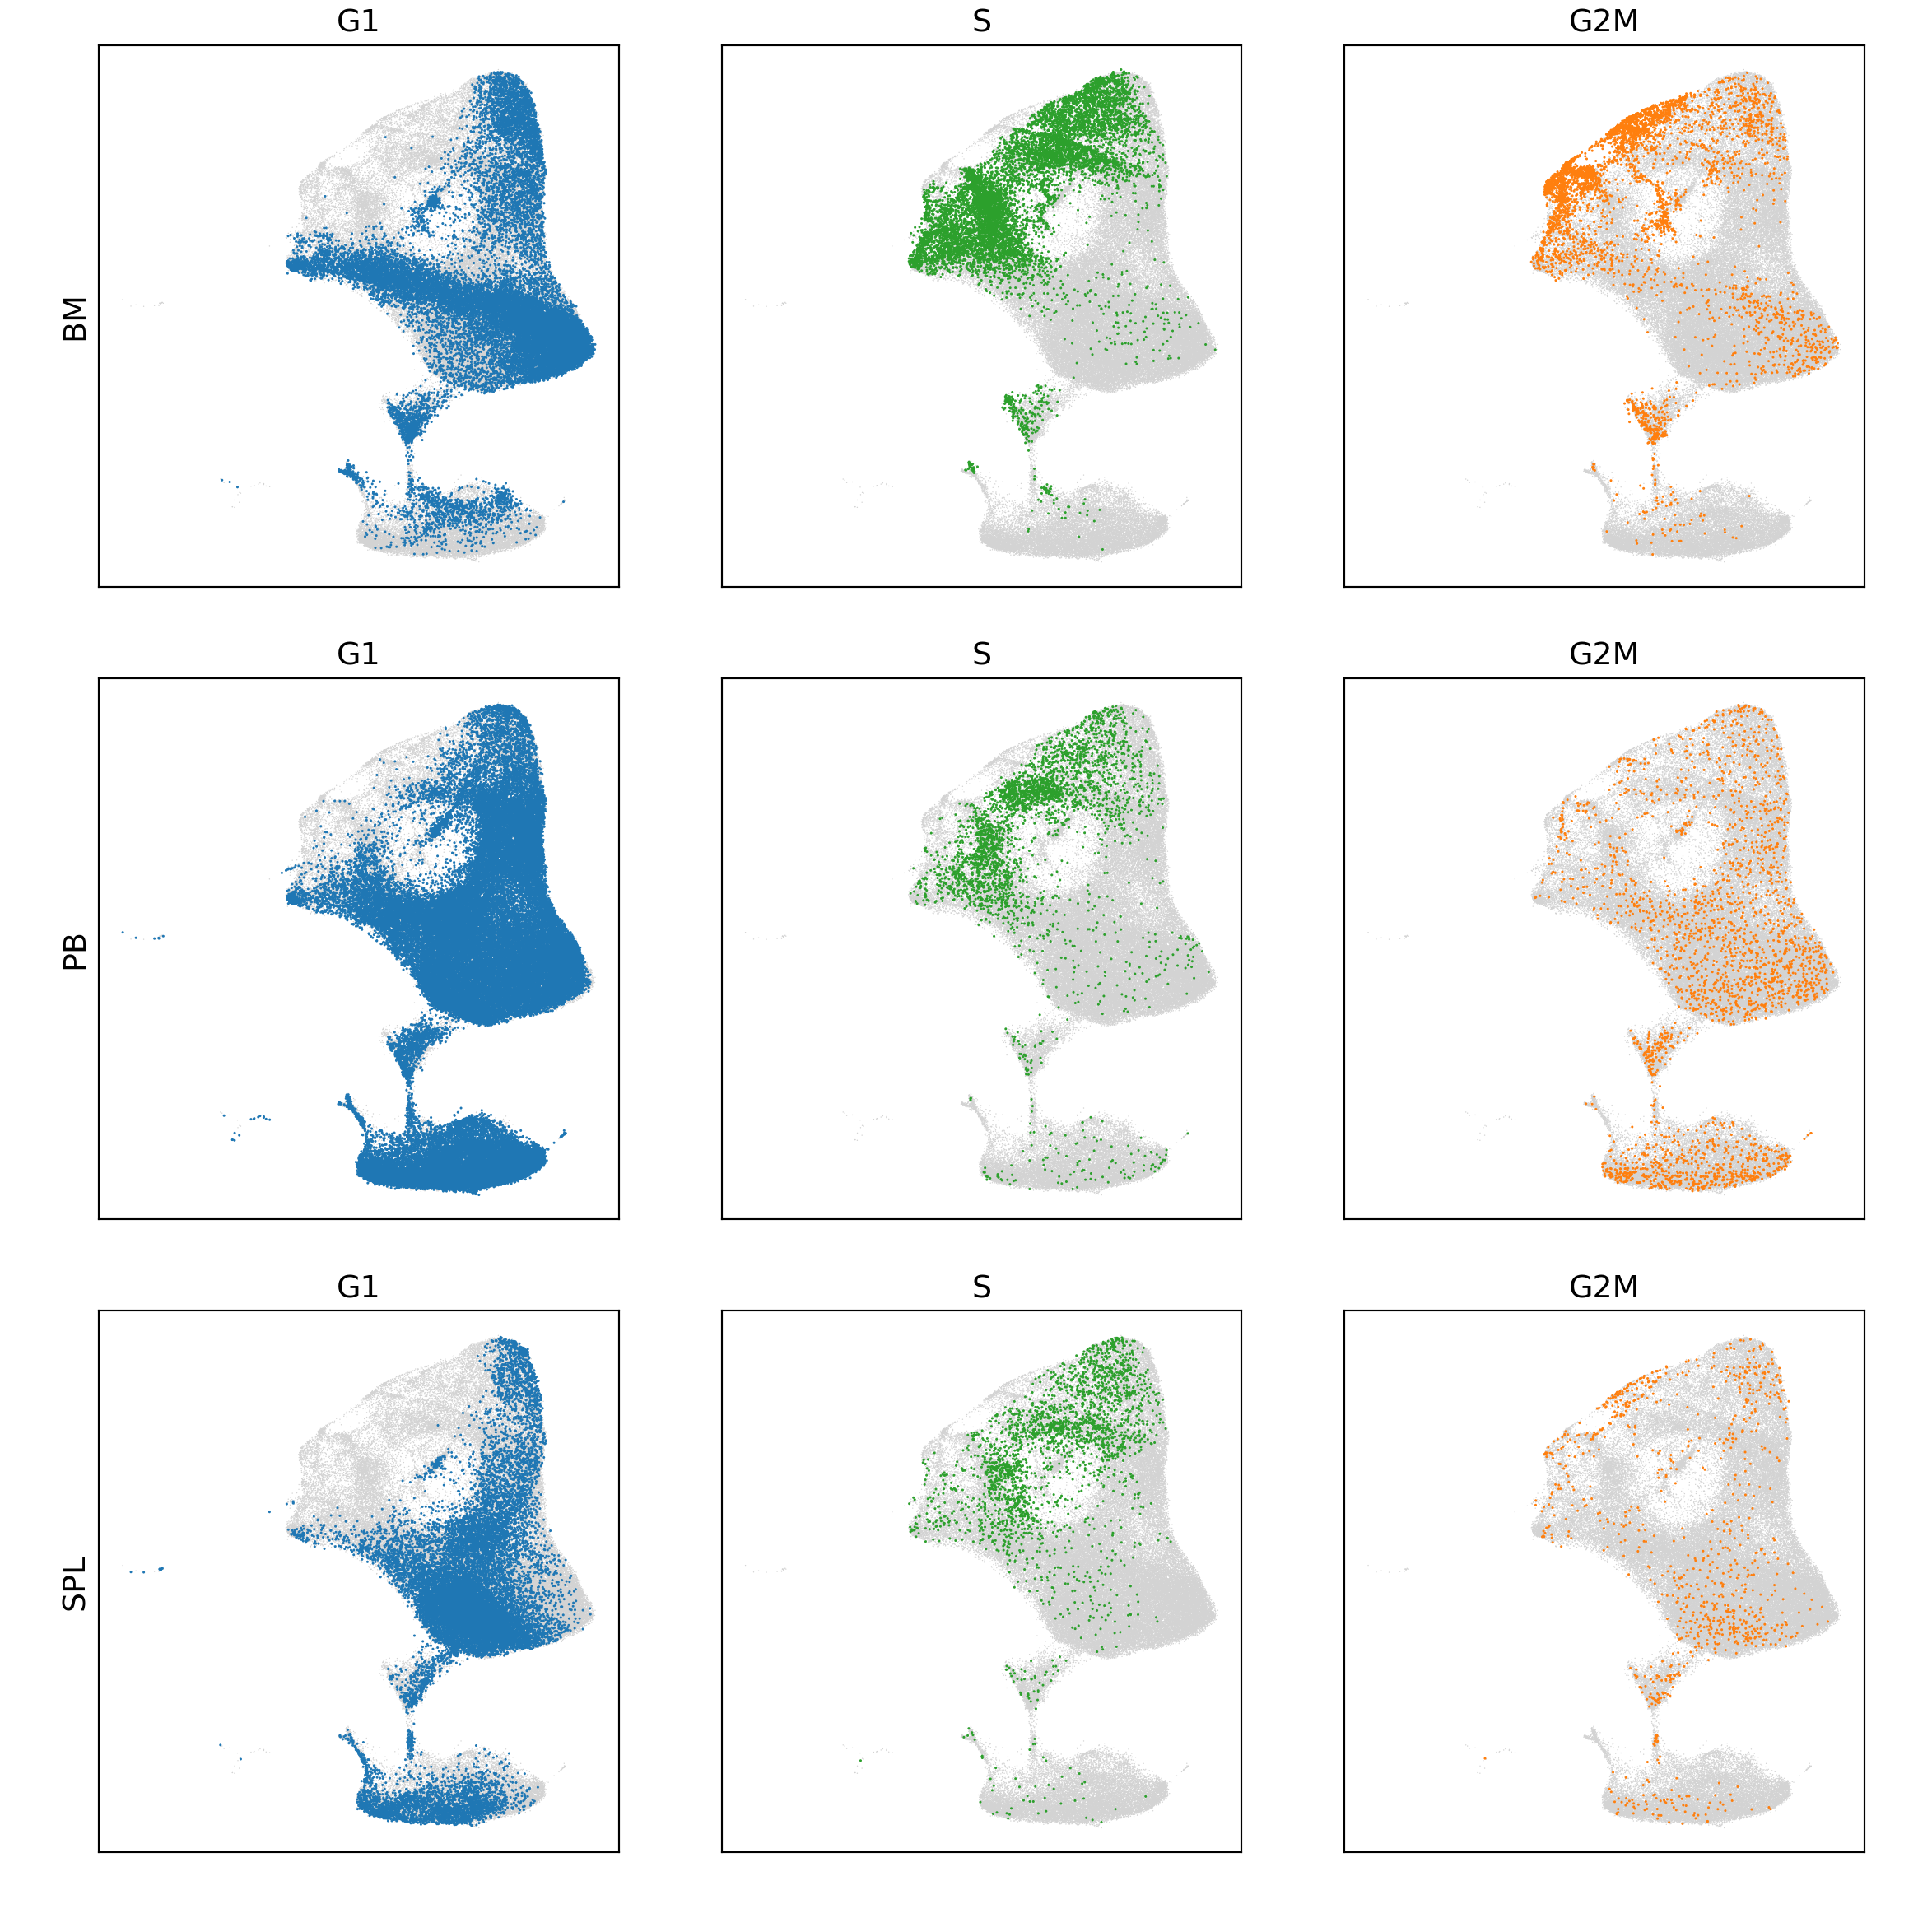

Text(254.83333333333334, 0.5, 'SPL')

In [34]:
fig, ax = plt.subplots(3,3, sharey=True, squeeze=True, figsize=(12,12))
fig.tight_layout()

ax = ax.ravel()

sc.pl.umap(selection, ax=ax[0])
sc.pl.umap(selection[np.logical_and(selection.obs.phase == 'G1', selection.obs.organ == 'BM' ), :], color=['phase'], ax=ax[0], title='G1')
ax[0].collections[1].set_sizes([5])

sc.pl.umap(selection, ax=ax[1])
sc.pl.umap(selection[np.logical_and(selection.obs.phase == 'S', selection.obs.organ == 'BM' ), :], color=['phase'], ax=ax[1], title='S')
ax[1].collections[1].set_sizes([5])

sc.pl.umap(selection, ax=ax[2])
sc.pl.umap(selection[np.logical_and(selection.obs.phase == 'G2M', selection.obs.organ == 'BM' ), :], color=['phase'], ax=ax[2], title='G2M')
ax[2].collections[1].set_sizes([5])



sc.pl.umap(selection, ax=ax[3])
sc.pl.umap(selection[np.logical_and(selection.obs.phase == 'G1', selection.obs.organ == 'PB' ), :], 
                 color=['phase'], ax=ax[3], title='G1')
ax[3].collections[1].set_sizes([5])

sc.pl.umap(selection, ax=ax[4])
sc.pl.umap(selection[np.logical_and(selection.obs.phase == 'S', selection.obs.organ == 'PB' ), :], 
                 color=['phase'], ax=ax[4], title='S')
ax[4].collections[1].set_sizes([5])

sc.pl.umap(selection, ax=ax[5])
sc.pl.umap(selection[np.logical_and(selection.obs.phase == 'G2M', selection.obs.organ == 'PB' ), :], 
                 color=['phase'], ax=ax[5], title='G2M')
ax[5].collections[1].set_sizes([5])



sc.pl.umap(selection, ax=ax[6])
sc.pl.umap(selection[np.logical_and(selection.obs.phase == 'G1', selection.obs.organ == 'SPL' ), :], 
                 color=['phase'], ax=ax[6], title='G1')
ax[6].collections[1].set_sizes([5])

sc.pl.umap(selection, ax=ax[7])
sc.pl.umap(selection[np.logical_and(selection.obs.phase == 'S', selection.obs.organ == 'SPL' ), :], 
                 color=['phase'], ax=ax[7], title='S')
ax[7].collections[1].set_sizes([5])

sc.pl.umap(selection, ax=ax[8])
sc.pl.umap(selection[np.logical_and(selection.obs.phase == 'G2M', selection.obs.organ == 'SPL' ), :], 
                 color=['phase'], ax=ax[8], title='G2M')
ax[8].collections[1].set_sizes([5])



for i in range(0, len(ax)):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].get_legend().set_visible(False)


ax[0].get_yaxis().set_visible(True)
ax[3].get_yaxis().set_visible(True)
ax[6].get_yaxis().set_visible(True)   

ax[0].set_ylabel('BM')
ax[3].set_ylabel('PB')
ax[6].set_ylabel('SPL')
    
#ax[0].get_xaxis().set_visible(False)
#ax[2].get_xaxis().set_visible(False)

#ax[1].get_yaxis().set_visible(False)
#ax[2].get_yaxis().set_visible(False)

#ax[0].get_legend().set_visible(False)
#ax[1].get_legend().set_visible(False)
#ax[2].get_legend().set_visible(False)

---

In [45]:
%%time
sc.write(prefix+'_COMBO10_NO_SPL3_DPT_CC_'+grouping.replace('.', '_')+'_minus_clusters_20_25_26', selection)

CPU times: user 2min 26s, sys: 3.66 s, total: 2min 29s
Wall time: 2min 37s


# RE-ENTRY

In [5]:
prefix = '20210111'

grouping = 'leiden.1.2'

In [6]:
selection = sc.read(prefix+'_COMBO10_NO_SPL3_DPT_CC_'+grouping.replace('.', '_')+'_minus_clusters_20_25_26')

In [7]:
umap = pd.DataFrame(selection.obsm['X_umap'], columns=['UMAP1', 'UMAP2'])
umap.head()

UMAP1     UMAP2
0  1.235005  5.486280
1 -2.034421  7.801731
2 -0.200764 -3.081061
3 -0.839644 -1.208814
4  0.779422 -2.303281

In [8]:
meta = selection.obs[['donor', 'organ', 'leiden.1.2',  'dpt_pseudotime', 
               'dpt_pseudotime_rank', 'S_score', 'G2M_score', 'phase']].copy()

In [9]:
meta.head()

donor organ leiden.1.2  dpt_pseudotime  \
_01_AAACCTGCACGTCTCT.1.0  DOD1    PB          2        0.073779   
_01_AAACCTGGTGTGACGA.1.0  DOD1    PB         13        0.130700   
_01_AAACCTGGTTCCGGCA.1.0  DOD1    PB          0        0.024719   
_01_AAACGGGGTCAAAGCG.1.0  DOD1    PB          0        0.029955   
_01_AAAGATGCACATGACT.1.0  DOD1    PB          0        0.028847   

                          dpt_pseudotime_rank   S_score  G2M_score phase  
_01_AAACCTGCACGTCTCT.1.0              66501.0 -0.152119  -0.060607    G1  
_01_AAACCTGGTGTGACGA.1.0              85706.0  0.375758   0.074574     S  
_01_AAACCTGGTTCCGGCA.1.0              22469.0 -0.161755  -0.091224    G1  
_01_AAACGGGGTCAAAGCG.1.0              34701.0 -0.093522  -0.103494    G1  
_01_AAAGATGCACATGACT.1.0              32307.0 -0.126899  -0.062752    G1

In [10]:
umap.index = meta.index

In [11]:
pd.concat([meta, umap], axis=1).head()

donor organ leiden.1.2  dpt_pseudotime  \
_01_AAACCTGCACGTCTCT.1.0  DOD1    PB          2        0.073779   
_01_AAACCTGGTGTGACGA.1.0  DOD1    PB         13        0.130700   
_01_AAACCTGGTTCCGGCA.1.0  DOD1    PB          0        0.024719   
_01_AAACGGGGTCAAAGCG.1.0  DOD1    PB          0        0.029955   
_01_AAAGATGCACATGACT.1.0  DOD1    PB          0        0.028847   

                          dpt_pseudotime_rank   S_score  G2M_score phase  \
_01_AAACCTGCACGTCTCT.1.0              66501.0 -0.152119  -0.060607    G1   
_01_AAACCTGGTGTGACGA.1.0              85706.0  0.375758   0.074574     S   
_01_AAACCTGGTTCCGGCA.1.0              22469.0 -0.161755  -0.091224    G1   
_01_AAACGGGGTCAAAGCG.1.0              34701.0 -0.093522  -0.103494    G1   
_01_AAAGATGCACATGACT.1.0              32307.0 -0.126899  -0.062752    G1   

                             UMAP1     UMAP2  
_01_AAACCTGCACGTCTCT.1.0  1.235005  5.486280  
_01_AAACCTGGTGTGACGA.1.0 -2.034421  7.801731  
_01_AAACCTGGTTCCGGCA.1.0 -0.200764 -3.081061  
_01_AAACGGGGTCAAAGCG.1.0 -0.839644 -1.208814  
_01_AAAGATGCACATGACT.1.0  0.779422 -2.303281

In [12]:
export_meta = pd.concat([meta, umap], axis=1)

In [13]:
outname = prefix+'_COMBO10_NO_SPL3_'+grouping.replace('.', '_')+'_selection_PSEUDOTIME_and_CC_metadata_UMAP_coords.txt.gz'

export_meta.to_csv('output/'+outname, sep='\t')

print(outname)

20210111_COMBO10_NO_SPL3_leiden_1_2_selection_PSEUDOTIME_and_CC_metadata_UMAP_coords.txt.gz


<IPython.core.display.Javascript object>


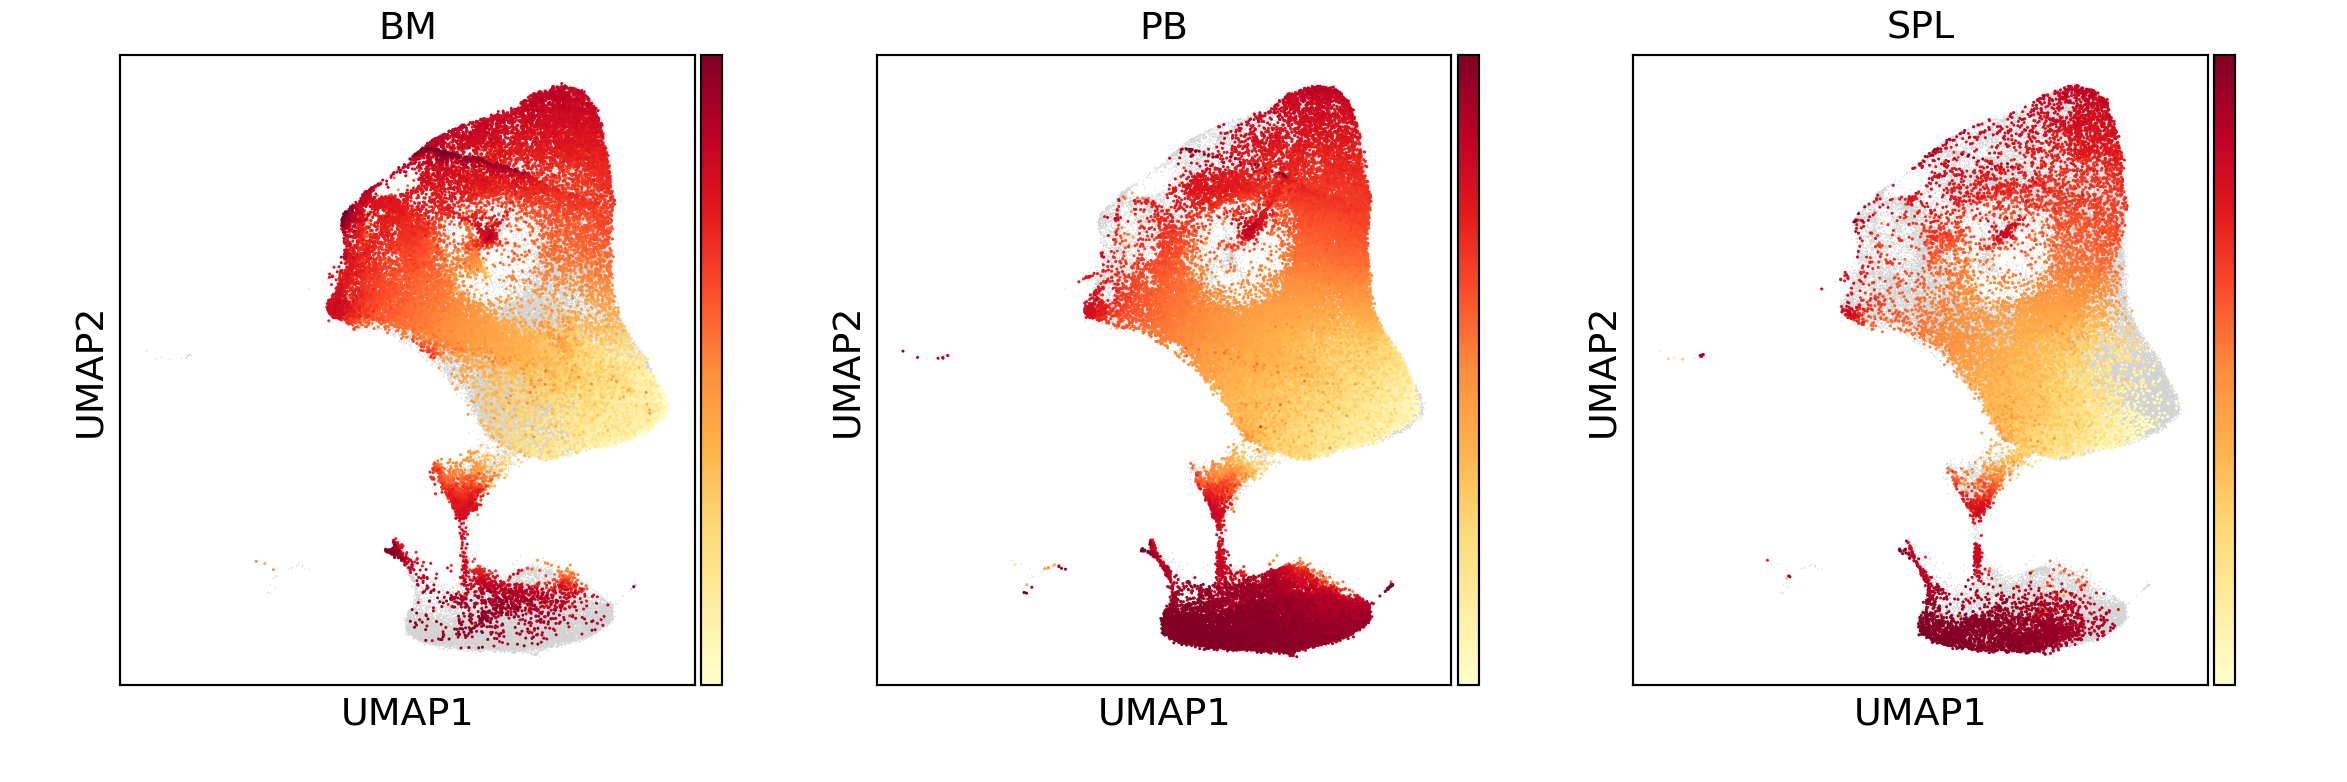

In [46]:
fig, ax = plt.subplots(1,3, sharey=True, squeeze=True, figsize=(12,4))
fig.tight_layout()

sc.pl.umap(selection, ax=ax[0])
sc.pl.umap(selection[selection.obs.organ == 'BM', :], 
                           color=['dpt_pseudotime_rank'], cmap='YlOrRd', ax=ax[0], title='BM')
ax[0].collections[1].set_sizes([5])

sc.pl.umap(selection, ax=ax[1])
sc.pl.umap(selection[selection.obs.organ == 'PB', :], 
                           color=['dpt_pseudotime_rank'], cmap='YlOrRd', ax=ax[1], title='PB')
ax[1].collections[1].set_sizes([5])

sc.pl.umap(selection, ax=ax[2])
sc.pl.umap(selection[selection.obs.organ == 'SPL', :], 
                           color=['dpt_pseudotime_rank'], cmap='YlOrRd', ax=ax[2], title='SPL')
ax[2].collections[1].set_sizes([5])

for x in range(1,4):
    cb = fig.get_axes()[-x]
    cb.set_yticklabels([])
    cb.tick_params(axis=u'both', which=u'both',length=0)

---

In [49]:
def count_cc_phase_cells_per_cluster_organ(data, organ, grouping):
    
    counts = []
    
    clusters = [str(x) for x in sorted([int(x) for x in selection.obs[grouping].unique()])]
    
    for c in clusters:
             
        curr_cluster = data[ data.obs[grouping] == str(c), : ].copy()

        # ---

        total = len( curr_cluster[ curr_cluster.obs['organ'] == organ, :] )

        tot_g1 = len(curr_cluster[ np.logical_and(curr_cluster.obs['organ'] == organ, 
                                                       curr_cluster.obs['phase'] == 'G1'), : ])

        tot_s = len(curr_cluster[ np.logical_and(curr_cluster.obs['organ'] == organ, 
                                                      curr_cluster.obs['phase'] == 'S'), : ])

        tot_g2m = len(curr_cluster[ np.logical_and(curr_cluster.obs['organ'] == organ, 
                                                        curr_cluster.obs['phase'] == 'G2M'), : ])
        
        counts.append([total, tot_g1, tot_s, tot_g2m])
       
    return counts

In [51]:
clusters = np.array([str(x) for x in sorted([int(x) for x in selection.obs[grouping].unique()])])
clusters = clusters.reshape(clusters.shape[0],-1)

---

### All donors

In [52]:
%%time
bm_counts = count_cc_phase_cells_per_cluster_organ(selection, 'BM', grouping)
pb_counts = count_cc_phase_cells_per_cluster_organ(selection, 'PB', grouping)
spl_counts = count_cc_phase_cells_per_cluster_organ(selection, 'SPL', grouping)

CPU times: user 10.1 s, sys: 7.16 s, total: 17.3 s
Wall time: 17.3 s


In [53]:
counts = np.hstack([clusters, bm_counts, pb_counts, spl_counts])

In [54]:
organs = ['BM', 'PB', 'SPL']

header = ['cluster']
for organ in organs:
    string = 'cells,%s_G1,%s_S,%s_G2M' % tuple([organ] * 3)
    header += string.split(',')

In [55]:
pd.DataFrame(counts, columns=header)

cluster cells BM_G1  BM_S BM_G2M cells PB_G1 PB_S PB_G2M cells SPL_G1  \
0        0   917   871     8     38  5461  5218   26    217  5570   5366   
1        1   948   861    56     31  7119  6822   54    243   887    857   
2        2  1990  1332   503    155  5718  5320  252    146  1120    719   
3        3   264   228     4     32  6672  6308   43    321  1869   1775   
4        4  4464  4312     8    144  3611  3438   14    159   637    604   
5        5  4292  4102    60    130  3806  3619   32    155   518    496   
6        6  2984  2554   334     96  3873  3605  160    108  1104    949   
7        7   433   407    10     16  4796  4571   37    188  2290   2191   
8        8  3255  1928   997    330  2151  1702  306    143  1366    826   
9        9  2782   947  1688    147  2123  1493  559     71   693    221   
10      10   901   850    35     16  3776  3618   32    126   558    522   
11      11   923   892     7     24  2007  1944    6     57  1930   1879   
12      12   437   415    13      9  2837  2719   24     94  1110   1029   
13      13  2112    19  1661    432  1448   422  952     74   560      0   
14      14  1353   873   218    262  1401  1190   55    156   708    560   
15      15  1899   611   987    301   719   479  208     32   182     80   
16      16  1920     2  1314    604   321    33  256     32   156      0   
17      17   517   285   152     80   738   610   90     38   193    113   
18      18    24    21     0      3  1116  1065    9     42    30     29   
19      19   927     1     7    919    59    16    2     41    99      0   
20      21   319   230    43     46    93    82    4      7   334    273   
21      22   492    21   346    125   118    73   25     20    38      2   
22      23   591   165   161    265    12     9    3      0     7      1   
23      24   224   194    23      7   222   213    5      4   111    102   

   SPL_S SPL_G2M  
0     38     166  
1     15      15  
2    351      50  
3     27      67  
4      2      31  
5      6      16  
6    131      24  
7     47      52  
8    426     114  
9    449      23  
10    24      12  
11    13      38  
12    60      21  
13   526      34  
14    50      98  
15    76      26  
16   123      33  
17    54      26  
18     0       1  
19     2      97  
20    34      27  
21    26      10  
22     3       3  
23     9       0

In [56]:
pd.DataFrame(counts, columns=header).to_csv('output/'+prefix+'_COMBO10_NO_SPL3_'+grouping.replace('.', '_')+'_cluster_counts_full.txt', 
                                            index=None, sep='\t')

---

In [65]:
def get_cluster_counts_per_donor_cc_phase(data, fields, donor_id, group_id, prefix):

    clusters = np.array([str(x) for x in sorted([int(x) for x in data.obs[grouping].unique()])])
    clusters = clusters.reshape(clusters.shape[0],-1)

    selection = data[data.obs.donor == donor_id, :].copy()

    sgr_counts = {}
    for field in fields:
        sgr_counts[field] = count_cc_phase_cells_per_cluster_organ(selection, field, grouping)

        
    counts = np.hstack([clusters])    
    for field in fields:    
        counts = np.hstack([counts, sgr_counts[field]])

    header = ['cluster']
    for field in fields:
        string = 'cells,%s_G1,%s_S,%s_G2M' % tuple([field] * 3)
        header += string.split(',')

    # still beware of the hardcoded section of this path    
    pd.DataFrame(counts, columns=header).to_csv('output/'+prefix+'_COMBO10_'+donor_id+'_'+group_id.replace('.', '_')+'_cluster_counts.txt', 
                                            index=None, sep='\t')
        
    return pd.DataFrame(counts, columns=header)

In [60]:
selection.obs.donor.unique()

['DOD1', 'DOD2', 'DOD3', 'DOD4', 'TQ198', 'BP62j', 'BP37d', 'BP74', 'BP1c', 'BP59h']
Categories (10, object): ['DOD1', 'DOD2', 'DOD3', 'DOD4', ..., 'BP37d', 'BP74', 'BP1c', 'BP59h']

In [61]:
organs = ['BM', 'PB', 'SPL']

### Donor 1

In [66]:
get_cluster_counts_per_donor_cc_phase(selection, organs, 'DOD1', grouping, prefix)

cluster cells BM_G1 BM_S BM_G2M cells PB_G1 PB_S PB_G2M cells SPL_G1 SPL_S  \
0        0    71    66    1      4   532   521    1     10  1128   1113     2   
1        1   349   327   16      6    79    77    1      1   250    243     3   
2        2   173    96   68      9   237   187   49      1   296    221    65   
3        3    35    33    1      1    30    30    0      0   718    697    10   
4        4   579   557    0     22   116   115    0      1   214    205     1   
5        5   976   954    3     19   311   299    4      8   253    246     2   
6        6   696   602   82     12   361   327   32      2   276    245    29   
7        7    57    53    2      2   300   291    4      5   491    473    15   
8        8   292   114  166     12   132    83   44      5   341    228   111   
9        9   568   157  398     13    83    49   33      1    79     41    38   
10      10   118   108    8      2   104   101    2      1   214    209     3   
11      11   185   181    2      2    80    79    0      1   403    391     3   
12      12    24    19    4      1   105    99    4      2   225    216     9   
13      13   292     0  253     39    37     0   36      1    67      0    66   
14      14    48    31   11      6    13    12    1      0    77     71     3   
15      15   365    50  272     43    10     1    9      0    19      7    11   
16      16   426     0  322    104     2     0    2      0    15      0     7   
17      17    83    25   50      8    19    11    7      1    31     23     8   
18      18     0     0    0      0     3     3    0      0    10      9     0   
19      19   173     1    0    172     2     1    0      1     7      0     0   
20      21     0     0    0      0     2     2    0      0     3      3     0   
21      22    81     4   62     15     0     0    0      0     3      1     2   
22      23     1     0    0      1     3     3    0      0     0      0     0   
23      24   103    99    2      2    30    29    1      0    56     54     2   

   SPL_G2M  
0       13  
1        4  
2       10  
3       11  
4        8  
5        5  
6        2  
7        3  
8        2  
9        0  
10       2  
11       9  
12       0  
13       1  
14       3  
15       1  
16       8  
17       0  
18       1  
19       7  
20       0  
21       0  
22       0  
23       0

---

### Donor 2

In [74]:
get_cluster_counts_per_donor_cc_phase(selection, organs, 'DOD2', grouping, prefix)

cluster cells BM_G1 BM_S BM_G2M cells PB_G1 PB_S PB_G2M cells SPL_G1 SPL_S  \
0        0   169   151    6     12   992   957   14     21   862    792    19   
1        1    40    23   17      0   182   174    4      4   218    200    12   
2        2   348   134  189     25   385   214  163      8   343    168   155   
3        3    16    14    1      1   135   133    0      2   691    639    14   
4        4  1048   996    3     49   415   405    1      9   227    211     1   
5        5   551   485   33     33   813   786   14     13   168    154     3   
6        6   346   194  140     12   753   635  112      6   174    117    51   
7        7    77    68    6      3   463   439   18      6   354    317    21   
8        8   617   209  339     69   480   270  181     29   326    192    96   
9        9   590    40  531     19   462    99  357      6   193     19   163   
10      10   179   157   19      3   208   195   13      0   172    150    14   
11      11    38    36    2      0   179   172    2      5    65     58     3   
12      12    53    45    6      2   168   152   16      0   195    173    18   
13      13   580     0  526     54   190     0  187      3   204      0   193   
14      14   130    72   37     21    39    27    7      5    59     32    10   
15      15   343    20  258     65   140    10  117     13    59      8    36   
16      16   384     0  341     43    94     0   84     10    70      0    62   
17      17    84    21   46     17   129    66   59      4    96     48    29   
18      18     1     1    0      0    21    21    0      0     3      3     0   
19      19   188     0    5    183    30     2    1     27    50      0     1   
20      21    59    53    5      1    78    68    4      6   273    224    28   
21      22   206     1  176     29    10     1    9      0     5      0     5   
22      23     5     2    2      1     2     0    2      0     4      1     1   
23      24    17     3   13      1     9     8    1      0    31     27     4   

   SPL_G2M  
0       51  
1        6  
2       20  
3       38  
4       15  
5       11  
6        6  
7       16  
8       38  
9       11  
10       8  
11       4  
12       4  
13      11  
14      17  
15      15  
16       8  
17      19  
18       0  
19      49  
20      21  
21       0  
22       2  
23       0

---

### Donor 3

In [75]:
get_cluster_counts_per_donor_cc_phase(selection, organs, 'DOD3', grouping, prefix)

cluster cells BM_G1 BM_S BM_G2M cells PB_G1 PB_S PB_G2M cells SPL_G1 SPL_S  \
0        0   647   626    1     20     0     0    0      0     0      0     0   
1        1   347   336    2      9     0     0    0      0     0      0     0   
2        2   897   798   45     54     0     0    0      0     0      0     0   
3        3   172   151    1     20     0     0    0      0     0      0     0   
4        4  1269  1243    1     25     0     0    0      0     0      0     0   
5        5  1154  1118    9     27     0     0    0      0     0      0     0   
6        6   743   703   24     16     0     0    0      0     0      0     0   
7        7   213   204    0      9     0     0    0      0     0      0     0   
8        8  1072   906   94     72     0     0    0      0     0      0     0   
9        9   377   259   84     34     0     0    0      0     0      0     0   
10      10   300   292    2      6     0     0    0      0     0      0     0   
11      11   182   178    0      4     0     0    0      0     0      0     0   
12      12   307   303    1      3     0     0    0      0     0      0     0   
13      13   501    18  319    164     0     0    0      0     0      0     0   
14      14   617   414   66    137     0     0    0      0     0      0     0   
15      15   369   250   82     37     0     0    0      0     0      0     0   
16      16   331     2  137    192     0     0    0      0     0      0     0   
17      17   215   179   12     24     0     0    0      0     0      0     0   
18      18    22    19    0      3     0     0    0      0     0      0     0   
19      19   164     0    0    164     0     0    0      0     0      0     0   
20      21     1     1    0      0     0     0    0      0     0      0     0   
21      22    85    13   35     37     0     0    0      0     0      0     0   
22      23     3     2    1      0     0     0    0      0     0      0     0   
23      24    69    66    1      2     0     0    0      0     0      0     0   

   SPL_G2M  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  
10       0  
11       0  
12       0  
13       0  
14       0  
15       0  
16       0  
17       0  
18       0  
19       0  
20       0  
21       0  
22       0  
23       0

---

### Donor 4

In [76]:
get_cluster_counts_per_donor_cc_phase(selection, organs, 'DOD4', grouping, prefix)

cluster cells BM_G1 BM_S BM_G2M cells PB_G1 PB_S PB_G2M cells SPL_G1 SPL_S  \
0        0    30    28    0      2     0     0    0      0  3580   3461    17   
1        1   212   175   21     16     0     0    0      0   419    414     0   
2        2   572   304  201     67     0     0    0      0   481    330   131   
3        3    41    30    1     10     0     0    0      0   460    439     3   
4        4  1568  1516    4     48     0     0    0      0   196    188     0   
5        5  1611  1545   15     51     0     0    0      0    97     96     1   
6        6  1199  1055   88     56     0     0    0      0   654    587    51   
7        7    86    82    2      2     0     0    0      0  1445   1401    11   
8        8  1274   699  398    177     0     0    0      0   699    406   219   
9        9  1247   491  675     81     0     0    0      0   421    161   248   
10      10   304   293    6      5     0     0    0      0   172    163     7   
11      11   518   497    3     18     0     0    0      0  1462   1430     7   
12      12    53    48    2      3     0     0    0      0   690    640    33   
13      13   739     1  563    175     0     0    0      0   289      0   267   
14      14   558   356  104     98     0     0    0      0   572    457    37   
15      15   822   291  375    156     0     0    0      0   104     65    29   
16      16   779     0  514    265     0     0    0      0    71      0    54   
17      17   135    60   44     31     0     0    0      0    66     42    17   
18      18     1     1    0      0     0     0    0      0    17     17     0   
19      19   402     0    2    400     0     0    0      0    42      0     1   
20      21   259   176   38     45     0     0    0      0    58     46     6   
21      22   120     3   73     44     0     0    0      0    30      1    19   
22      23   582   161  158    263     0     0    0      0     3      0     2   
23      24    35    26    7      2     0     0    0      0    24     21     3   

   SPL_G2M  
0      102  
1        5  
2       20  
3       18  
4        8  
5        0  
6       16  
7       33  
8       74  
9       12  
10       2  
11      25  
12      17  
13      22  
14      78  
15      10  
16      17  
17       7  
18       0  
19      41  
20       6  
21      10  
22       1  
23       0

---

### TQ198

In [77]:
get_cluster_counts_per_donor_cc_phase(selection, organs, 'TQ198', grouping, prefix)

cluster cells BM_G1 BM_S BM_G2M cells PB_G1 PB_S PB_G2M cells SPL_G1 SPL_S  \
0        0     0     0    0      0   409   386    2     21     0      0     0   
1        1     0     0    0      0   715   690    6     19     0      0     0   
2        2     0     0    0      0   533   518    5     10     0      0     0   
3        3     0     0    0      0   479   456    8     15     0      0     0   
4        4     0     0    0      0   225   217    1      7     0      0     0   
5        5     0     0    0      0   199   181    2     16     0      0     0   
6        6     0     0    0      0   274   265    0      9     0      0     0   
7        7     0     0    0      0   374   359    2     13     0      0     0   
8        8     0     0    0      0   218   184   17     17     0      0     0   
9        9     0     0    0      0   164   130   25      9     0      0     0   
10      10     0     0    0      0   292   283    3      6     0      0     0   
11      11     0     0    0      0   156   149    2      5     0      0     0   
12      12     0     0    0      0   263   258    1      4     0      0     0   
13      13     0     0    0      0   157    44  107      6     0      0     0   
14      14     0     0    0      0   170   133   16     21     0      0     0   
15      15     0     0    0      0    54    46    6      2     0      0     0   
16      16     0     0    0      0    18     3   15      0     0      0     0   
17      17     0     0    0      0   125   108    6     11     0      0     0   
18      18     0     0    0      0    96    92    2      2     0      0     0   
19      19     0     0    0      0     4     1    0      3     0      0     0   
20      21     0     0    0      0     0     0    0      0     0      0     0   
21      22     0     0    0      0     4     3    1      0     0      0     0   
22      23     0     0    0      0     1     1    0      0     0      0     0   
23      24     0     0    0      0    10    10    0      0     0      0     0   

   SPL_G2M  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  
10       0  
11       0  
12       0  
13       0  
14       0  
15       0  
16       0  
17       0  
18       0  
19       0  
20       0  
21       0  
22       0  
23       0

---

### BP62j

In [78]:
get_cluster_counts_per_donor_cc_phase(selection, organs, 'BP62j', grouping, prefix)

cluster cells BM_G1 BM_S BM_G2M cells PB_G1 PB_S PB_G2M cells SPL_G1 SPL_S  \
0        0     0     0    0      0   724   683    2     39     0      0     0   
1        1     0     0    0      0   225   220    2      3     0      0     0   
2        2     0     0    0      0   460   453    1      6     0      0     0   
3        3     0     0    0      0   262   248    1     13     0      0     0   
4        4     0     0    0      0   514   482    3     29     0      0     0   
5        5     0     0    0      0   415   390    1     24     0      0     0   
6        6     0     0    0      0   451   433    2     16     0      0     0   
7        7     0     0    0      0   582   561    0     21     0      0     0   
8        8     0     0    0      0   170   153    4     13     0      0     0   
9        9     0     0    0      0   265   249    8      8     0      0     0   
10      10     0     0    0      0   389   374    0     15     0      0     0   
11      11     0     0    0      0   470   461    0      9     0      0     0   
12      12     0     0    0      0   303   292    0     11     0      0     0   
13      13     0     0    0      0   100    47   48      5     0      0     0   
14      14     0     0    0      0   161   133    4     24     0      0     0   
15      15     0     0    0      0   117   109    5      3     0      0     0   
16      16     0     0    0      0    29     7   19      3     0      0     0   
17      17     0     0    0      0    58    52    2      4     0      0     0   
18      18     0     0    0      0    34    31    1      2     0      0     0   
19      19     0     0    0      0     4     3    0      1     0      0     0   
20      21     0     0    0      0     1     1    0      0     0      0     0   
21      22     0     0    0      0     6     5    0      1     0      0     0   
22      23     0     0    0      0     2     1    1      0     0      0     0   
23      24     0     0    0      0     3     3    0      0     0      0     0   

   SPL_G2M  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  
10       0  
11       0  
12       0  
13       0  
14       0  
15       0  
16       0  
17       0  
18       0  
19       0  
20       0  
21       0  
22       0  
23       0

---

### BP37d

In [79]:
get_cluster_counts_per_donor_cc_phase(selection, organs, 'BP37d', grouping, prefix)

cluster cells BM_G1 BM_S BM_G2M cells PB_G1 PB_S PB_G2M cells SPL_G1 SPL_S  \
0        0     0     0    0      0   469   438    0     31     0      0     0   
1        1     0     0    0      0   581   563    5     13     0      0     0   
2        2     0     0    0      0   657   641    3     13     0      0     0   
3        3     0     0    0      0   497   473    5     19     0      0     0   
4        4     0     0    0      0   284   273    1     10     0      0     0   
5        5     0     0    0      0   286   272    2     12     0      0     0   
6        6     0     0    0      0   276   261    2     13     0      0     0   
7        7     0     0    0      0   498   464    0     34     0      0     0   
8        8     0     0    0      0   207   185    5     17     0      0     0   
9        9     0     0    0      0   210   169   30     11     0      0     0   
10      10     0     0    0      0   310   295    1     14     0      0     0   
11      11     0     0    0      0   242   233    1      8     0      0     0   
12      12     0     0    0      0   299   286    0     13     0      0     0   
13      13     0     0    0      0   130    52   71      7     0      0     0   
14      14     0     0    0      0    74    62    2     10     0      0     0   
15      15     0     0    0      0    66    54    9      3     0      0     0   
16      16     0     0    0      0    34     6   25      3     0      0     0   
17      17     0     0    0      0    97    90    4      3     0      0     0   
18      18     0     0    0      0    27    27    0      0     0      0     0   
19      19     0     0    0      0     4     2    0      2     0      0     0   
20      21     0     0    0      0     2     2    0      0     0      0     0   
21      22     0     0    0      0     5     4    0      1     0      0     0   
22      23     0     0    0      0     1     1    0      0     0      0     0   
23      24     0     0    0      0    16    15    0      1     0      0     0   

   SPL_G2M  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  
10       0  
11       0  
12       0  
13       0  
14       0  
15       0  
16       0  
17       0  
18       0  
19       0  
20       0  
21       0  
22       0  
23       0

---

### BP74

In [80]:
get_cluster_counts_per_donor_cc_phase(selection, organs, 'BP74', grouping, prefix)

cluster cells BM_G1 BM_S BM_G2M cells PB_G1 PB_S PB_G2M cells SPL_G1 SPL_S  \
0        0     0     0    0      0   529   514    0     15     0      0     0   
1        1     0     0    0      0   999   982    4     13     0      0     0   
2        2     0     0    0      0   617   605    1     11     0      0     0   
3        3     0     0    0      0   805   790    3     12     0      0     0   
4        4     0     0    0      0   385   367    1     17     0      0     0   
5        5     0     0    0      0   271   264    0      7     0      0     0   
6        6     0     0    0      0   347   345    1      1     0      0     0   
7        7     0     0    0      0   537   528    0      9     0      0     0   
8        8     0     0    0      0   170   154   12      4     0      0     0   
9        9     0     0    0      0   235   190   39      6     0      0     0   
10      10     0     0    0      0   441   432    2      7     0      0     0   
11      11     0     0    0      0   254   249    0      5     0      0     0   
12      12     0     0    0      0   366   363    0      3     0      0     0   
13      13     0     0    0      0   137    26  110      1     0      0     0   
14      14     0     0    0      0   119   101    2     16     0      0     0   
15      15     0     0    0      0    77    66   10      1     0      0     0   
16      16     0     0    0      0    34     2   31      1     0      0     0   
17      17     0     0    0      0    58    56    2      0     0      0     0   
18      18     0     0    0      0   189   188    0      1     0      0     0   
19      19     0     0    0      0     6     2    1      3     0      0     0   
20      21     0     0    0      0     1     1    0      0     0      0     0   
21      22     0     0    0      0    14    10    1      3     0      0     0   
22      23     0     0    0      0     0     0    0      0     0      0     0   
23      24     0     0    0      0    62    61    1      0     0      0     0   

   SPL_G2M  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  
10       0  
11       0  
12       0  
13       0  
14       0  
15       0  
16       0  
17       0  
18       0  
19       0  
20       0  
21       0  
22       0  
23       0

---

### BP1c

In [81]:
get_cluster_counts_per_donor_cc_phase(selection, organs, 'BP1c', grouping, prefix)

cluster cells BM_G1 BM_S BM_G2M cells PB_G1 PB_S PB_G2M cells SPL_G1 SPL_S  \
0        0     0     0    0      0  1129  1086    3     40     0      0     0   
1        1     0     0    0      0   971   941    6     24     0      0     0   
2        2     0     0    0      0  1624  1557   20     47     0      0     0   
3        3     0     0    0      0   785   751    5     29     0      0     0   
4        4     0     0    0      0  1033   990    1     42     0      0     0   
5        5     0     0    0      0  1083  1038    2     43     0      0     0   
6        6     0     0    0      0   929   899    4     26     0      0     0   
7        7     0     0    0      0  1254  1213   10     31     0      0     0   
8        8     0     0    0      0   536   484   22     30     0      0     0   
9        9     0     0    0      0   414   372   26     16     0      0     0   
10      10     0     0    0      0  1058  1022    6     30     0      0     0   
11      11     0     0    0      0   456   445    1     10     0      0     0   
12      12     0     0    0      0   724   701    2     21     0      0     0   
13      13     0     0    0      0   473   201  237     35     0      0     0   
14      14     0     0    0      0   279   257    7     15     0      0     0   
15      15     0     0    0      0   154   136   17      1     0      0     0   
16      16     0     0    0      0    53    11   34      8     0      0     0   
17      17     0     0    0      0   170   159    4      7     0      0     0   
18      18     0     0    0      0    52    51    0      1     0      0     0   
19      19     0     0    0      0     2     1    0      1     0      0     0   
20      21     0     0    0      0     2     2    0      0     0      0     0   
21      22     0     0    0      0    35    20    7      8     0      0     0   
22      23     0     0    0      0     1     1    0      0     0      0     0   
23      24     0     0    0      0    23    22    0      1     0      0     0   

   SPL_G2M  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  
10       0  
11       0  
12       0  
13       0  
14       0  
15       0  
16       0  
17       0  
18       0  
19       0  
20       0  
21       0  
22       0  
23       0

---

### BP59h

In [82]:
get_cluster_counts_per_donor_cc_phase(selection, organs, 'BP59h', grouping, prefix)

cluster cells BM_G1 BM_S BM_G2M cells PB_G1 PB_S PB_G2M cells SPL_G1 SPL_S  \
0        0     0     0    0      0   677   633    4     40     0      0     0   
1        1     0     0    0      0  3367  3175   26    166     0      0     0   
2        2     0     0    0      0  1205  1145   10     50     0      0     0   
3        3     0     0    0      0  3679  3427   21    231     0      0     0   
4        4     0     0    0      0   639   589    6     44     0      0     0   
5        5     0     0    0      0   428   389    7     32     0      0     0   
6        6     0     0    0      0   482   440    7     35     0      0     0   
7        7     0     0    0      0   788   716    3     69     0      0     0   
8        8     0     0    0      0   238   189   21     28     0      0     0   
9        9     0     0    0      0   290   235   41     14     0      0     0   
10      10     0     0    0      0   974   916    5     53     0      0     0   
11      11     0     0    0      0   170   156    0     14     0      0     0   
12      12     0     0    0      0   609   568    1     40     0      0     0   
13      13     0     0    0      0   224    52  156     16     0      0     0   
14      14     0     0    0      0   546   465   16     65     0      0     0   
15      15     0     0    0      0   101    57   35      9     0      0     0   
16      16     0     0    0      0    57     4   46      7     0      0     0   
17      17     0     0    0      0    82    68    6      8     0      0     0   
18      18     0     0    0      0   694   652    6     36     0      0     0   
19      19     0     0    0      0     7     4    0      3     0      0     0   
20      21     0     0    0      0     7     6    0      1     0      0     0   
21      22     0     0    0      0    44    30    7      7     0      0     0   
22      23     0     0    0      0     2     2    0      0     0      0     0   
23      24     0     0    0      0    69    65    2      2     0      0     0   

   SPL_G2M  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  
10       0  
11       0  
12       0  
13       0  
14       0  
15       0  
16       0  
17       0  
18       0  
19       0  
20       0  
21       0  
22       0  
23       0

---